In [2]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
import joblib

# 2. Load and Clean the Data
df = pd.read_csv(r"/content/adult 3.csv")
df.replace(' ?', np.nan, inplace=True)
df.dropna(inplace=True)

# 3. Encode Categorical Variables
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4. Split Data into Features and Target
X = df.drop("income", axis=1)
y = df["income"]

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Initialize and Train LightGBM Model
model = LGBMClassifier()
model.fit(X_train, y_train)

# 7. Predict and Evaluate
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# 8. Display Evaluation Metrics
print("LightGBM Model Performance Summary:\n")
print(f"Accuracy       : {report['accuracy']:.2f}")
print(f"F1 Score (>50K): {report['1']['f1-score']:.2f}")
print(f"F1 Score (<=50K): {report['0']['f1-score']:.2f}")

# 9. Save the Trained Model
joblib.dump(model, "model_lightgbm_v2.pkl")

# 10. Conclusion
# The LightGBM model performs very well for binary income classification.
# It's efficient, accurate, and ideal for deployment in a real-world app

[LightGBM] [Info] Number of positive: 9397, number of negative: 29676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240499 -> initscore=-1.149948
[LightGBM] [Info] Start training from score -1.149948
LightGBM Model Performance Summary:

Accuracy       : 0.88
F1 Score (>50K): 0.72
F1 Score (<=50K): 0.92


['model_lightgbm_v2.pkl']

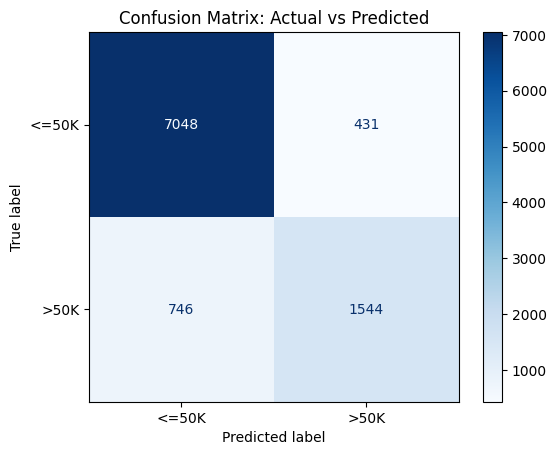

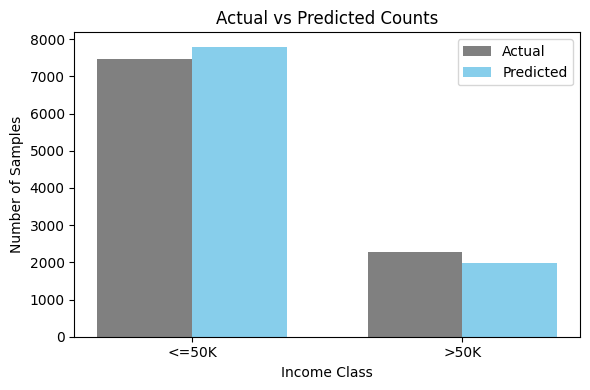

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      7479
        >50K       0.78      0.67      0.72      2290

    accuracy                           0.88      9769
   macro avg       0.84      0.81      0.82      9769
weighted avg       0.88      0.88      0.88      9769



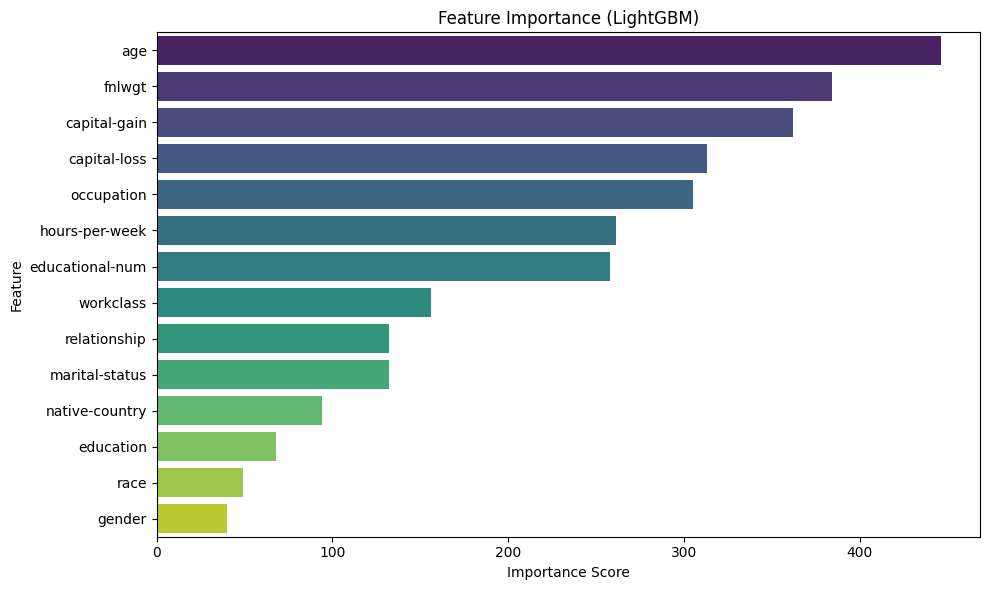

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import joblib

# Assuming model and X_test, y_test are already available
model = joblib.load("model_lightgbm_v2.pkl")
y_pred = model.predict(X_test)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Actual vs Predicted")
plt.show()

# 2. Actual vs Predicted Bar Plot
actual_counts = pd.Series(y_test).value_counts().sort_index()
predicted_counts = pd.Series(y_pred).value_counts().sort_index()
labels = ["<=50K", ">50K"]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, actual_counts, width, label="Actual", color="gray")
plt.bar(x + width/2, predicted_counts, width, label="Predicted", color="skyblue")
plt.xticks(x, labels)
plt.title("Actual vs Predicted Counts")
plt.xlabel("Income Class")
plt.ylabel("Number of Samples")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Classification Report (printed)
report = classification_report(y_test, y_pred, target_names=["<=50K", ">50K"])
print("Classification Report:\n", report)

# 4. Feature Importance Bar Plot (fixed for warning)
feature_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_df,
    x="Importance",
    y="Feature",
    palette="viridis",
    hue="Feature",
    dodge=False,
    legend=False
)
plt.title("Feature Importance (LightGBM)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [4]:
! pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [5]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Load trained model
model = joblib.load("model_lightgbm_v2.pkl")

st.set_page_config(page_title="Employee Salary Estimator", layout="centered")

# Custom CSS to style the app
st.markdown("""
    <style>
    .main {
        background-color: #f9f9f9;
        padding: 2rem;
        border-radius: 10px;
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
        font-family: 'Segoe UI', sans-serif;
    }
    h1 {
        color: #1f77b4;
        text-align: center;
    }
    .stButton > button {
        background-color: #1f77b4;
        color: white;
        border-radius: 8px;
        height: 3em;
        width: 100%;
        font-size: 16px;
    }
    .stSuccess {
        background-color: #d4edda;
        color: #155724;
        padding: 1rem;
        border-radius: 8px;
        font-size: 18px;
    }
    </style>
""", unsafe_allow_html=True)

st.markdown("<div class='main'>", unsafe_allow_html=True)

st.title("💼 Employee Salary Estimator")
st.write("Use the form below to estimate an employee's expected monthly salary.")
st.markdown("---")

# Actual category labels
workclass_options = ["Private", "Self-emp-not-inc", "Self-emp-inc", "Federal-gov", "Local-gov", "State-gov", "Without-pay", "Never-worked"]
education_options = ["Bachelors", "HS-grad", "11th", "Masters", "9th", "Some-college", "Assoc-acdm", "Assoc-voc", "Doctorate", "7th-8th", "Prof-school", "5th-6th", "10th", "1st-4th", "Preschool", "12th"]
marital_status_options = ["Married-civ-spouse", "Divorced", "Never-married", "Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse"]
occupation_options = ["Tech-support", "Craft-repair", "Other-service", "Sales", "Exec-managerial", "Prof-specialty", "Handlers-cleaners", "Machine-op-inspct", "Adm-clerical", "Farming-fishing", "Transport-moving", "Priv-house-serv", "Protective-serv", "Armed-Forces", "Unknown"]
relationship_options = ["Wife", "Own-child", "Husband", "Not-in-family", "Other-relative", "Unmarried"]
race_options = ["White", "Black", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other"]
native_country_options = ["United-States", "Mexico", "Philippines", "Germany", "Canada", "India", "China", "Cuba", "England", "Japan", "South"]

# Collect user inputs
age = st.slider("Age", 18, 90, 30)
workclass = st.selectbox("Workclass", workclass_options)
education = st.selectbox("Education", education_options)
education_num = st.slider("Education Number", 1, 16, 9)
marital_status = st.selectbox("Marital Status", marital_status_options)
occupation = st.selectbox("Occupation", occupation_options)
relationship = st.selectbox("Relationship", relationship_options)
race = st.selectbox("Race", race_options)
sex = st.selectbox("Sex", ["Female", "Male"])
capital_gain = st.number_input("Capital Gain", 0)
capital_loss = st.number_input("Capital Loss", 0)
hours_per_week = st.slider("Hours Per Week", 1, 99, 40)
native_country = st.selectbox("Native Country", native_country_options)
fnlwgt = st.number_input("Final Weight (fnlwgt)", 0)

# Encode inputs
workclass_encoded = workclass_options.index(workclass)
education_encoded = education_options.index(education)
marital_status_encoded = marital_status_options.index(marital_status)
occupation_encoded = occupation_options.index(occupation)
relationship_encoded = relationship_options.index(relationship)
race_encoded = race_options.index(race)
native_country_encoded = native_country_options.index(native_country)
sex_encoded = 1 if sex == "Male" else 0

# Input feature order must match model training
input_data = np.array([[
    age, workclass_encoded, education_encoded, education_num, marital_status_encoded,
    occupation_encoded, relationship_encoded, race_encoded, sex_encoded, capital_gain,
    capital_loss, hours_per_week, native_country_encoded, fnlwgt
]])

# Predict and estimate salary
if st.button("Estimate Salary"):
    prediction = model.predict(input_data)

    if prediction[0] == 1:
        salary = "₹75,000/month (High Income Group)"
        salary_value = 75000
    else:
        salary = "₹30,000/month (Lower Income Group)"
        salary_value = 30000

    st.success(f"Estimated Salary: {salary}")

    # Salary bar chart
    st.write("### Salary Estimate Chart")
    fig, ax = plt.subplots()
    ax.bar(["Predicted Salary"], [salary_value], color="#1f77b4")
    ax.set_ylabel("INR")
    ax.set_ylim(0, 100000)
    st.pyplot(fig)

st.markdown("</div>", unsafe_allow_html=True)


Writing app.py


In [6]:
! ngrok authtoken 304oAVy8y1G3THiC0Lepdh2c89P_3AAmYkXgpSi8ufQhkNF9c

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [7]:
import os

import threading

def run_streamlit():
  os.system('streamlit run app.py --server.port 8501')

thread=threading.Thread(target=run_streamlit)
thread.start()

In [8]:
from pyngrok import ngrok
import time

#Wait a few seconds to make sure Streamlit started
time.sleep(5)

# Create a tunnel to the Streamlit port 8501

public_url = ngrok.connect(8501)

print("Your Streamlit app is live here:", public_url)


Your Streamlit app is live here: NgrokTunnel: "https://764106067d5b.ngrok-free.app" -> "http://localhost:8501"
